In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

from rxitect.chem.utils import calc_fp
from rxitect.process_qsar_data import load_and_transform

In [3]:
raw_path="../data/raw/ligand_raw.tsv"
# targets=["CHEMBL226", "CHEMBL240", "CHEMBL251"]
targets=["CHEMBL226"]
cols=[
    "target_chembl_id",
    "smiles",
    "pchembl_value",
    "comment",
    "standard_type",
    "standard_relation",
    "document_year",
    ]
px_placeholder=3.99

In [4]:
dataset = load_and_transform(raw_path,
                             targets,
                             cols,
                             px_placeholder)

res = dataset.copy()
X, y = calc_fp(dataset["smiles"]), dataset["pchembl_value"]
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, res.index, test_size=0.2, random_state=42)

Calculating physico-chemical properties: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 360.58it/s]


In [15]:
max_features = ["sqrt", "log2", "auto"]
params = {"max_features": max_features}
reg = RandomForestRegressor(n_estimators=1_000, n_jobs=-1)

gs2 = GridSearchCV(reg, param_grid=params, n_jobs=10, cv=5, return_train_score=True)

In [16]:
%time gs_results = gs2.fit(X_train, y_train, sample_weight=[1 if px_val >= 4 else 0.1 for px_val in y_train])

/home/julius/miniconda3/envs/rxt-dev/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


CPU times: user 19min 14s, sys: 3.58 s, total: 19min 18s
Wall time: 9min 43s


/home/julius/miniconda3/envs/rxt-dev/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/julius/miniconda3/envs/rxt-dev/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/julius/miniconda3/envs/rxt-dev/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remov

In [17]:
gs_results.cv_results_

{'mean_fit_time': array([ 26.64692764,  18.56722255, 476.89196577]),
 'std_fit_time': array([0.83885241, 0.25106217, 7.99794799]),
 'mean_score_time': array([2.01708465, 1.46205673, 0.82697372]),
 'std_score_time': array([0.19289043, 0.07571978, 0.56846012]),
 'param_max_features': masked_array(data=['sqrt', 'log2', 'auto'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 'sqrt'},
  {'max_features': 'log2'},
  {'max_features': 'auto'}],
 'split0_test_score': array([0.6917232 , 0.67516516, 0.69936202]),
 'split1_test_score': array([0.61988434, 0.60736925, 0.61381949]),
 'split2_test_score': array([0.63215502, 0.62638676, 0.63974714]),
 'split3_test_score': array([0.61952677, 0.60666428, 0.6195254 ]),
 'split4_test_score': array([0.6539664 , 0.64400387, 0.64977639]),
 'mean_test_score': array([0.64345115, 0.63191786, 0.64444609]),
 'std_test_score': array([0.02718873, 0.02564126, 0.03041474]),
 'rank_test_score': 

In [29]:
gs2.best_estimator_.score(X=X_test, y=y_test, sample_weight=[1 if px_val >= 4 else 0.1 for px_val in y_test])

0.5980021433624763

In [36]:
df_gs = pd.DataFrame(data=gs2.cv_results_)

In [37]:
df_gs.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,26.646928,0.838852,2.017085,0.19289,sqrt,{'max_features': 'sqrt'},0.691723,0.619884,0.632155,0.619527,...,0.643451,0.027189,2,0.949971,0.952310,0.950648,0.952360,0.951344,0.951327,0.000931
1,18.567223,0.251062,1.462057,0.07572,log2,{'max_features': 'log2'},0.675165,0.607369,0.626387,0.606664,...,0.631918,0.025641,3,0.948153,0.950854,0.949015,0.951229,0.949813,0.949813,0.001138
2,476.891966,7.997948,0.826974,0.56846,auto,{'max_features': 'auto'},0.699362,0.613819,0.639747,0.619525,...,0.644446,0.030415,1,0.949503,0.952610,0.951023,0.953181,0.950941,0.951452,0.001309


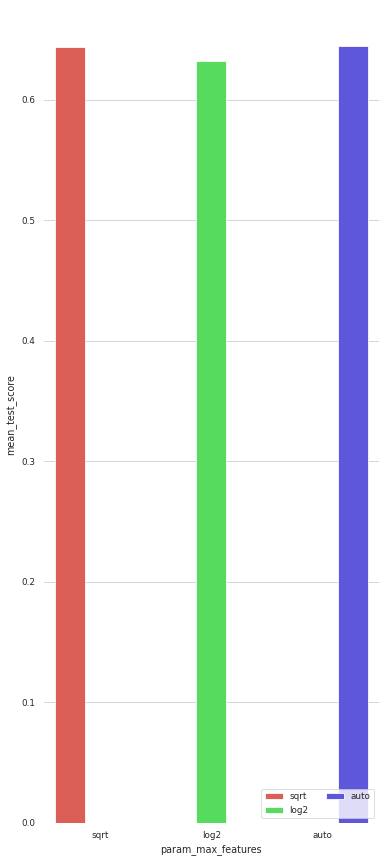

In [47]:
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

sns.set_context('paper')

f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x = 'param_max_features', y = 'mean_test_score', hue = 'param_max_features', data = df_gs,
            palette = 'hls',
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,
            capsize=0.05,
            ci = 'sd'   
            )

ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left = True, bottom = True)

In [57]:
df_gs.filter(regex="split\d_test_score").columns

Index(['split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'],
      dtype='object')

In [61]:
reg_sqrt = RandomForestRegressor(n_estimators=1_000, max_features="sqrt", n_jobs=-1)

In [63]:
reg_sqrt.fit(X_train, y_train, sample_weight=[1 if px_val >= 4 else 0.1 for px_val in y_train])

RandomForestRegressor(max_features='sqrt', n_estimators=1000, n_jobs=-1)

In [67]:
preds = reg_sqrt.predict(X_test)

<AxesSubplot:>

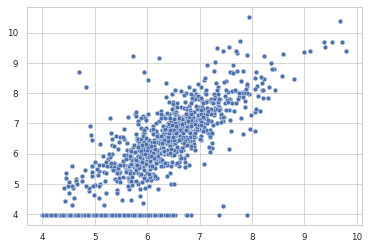

In [68]:
sns.scatterplot(x=preds, y=y_test.values,)

In [70]:
import joblib

In [71]:
old_reg = joblib.load("/home/julius/Downloads/RF_REG_CHEMBL226.pkg")

/home/julius/miniconda3/envs/rxt-dev/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/julius/miniconda3/envs/rxt-dev/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [74]:
old_preds = old_reg.predict(X_test)

<AxesSubplot:>

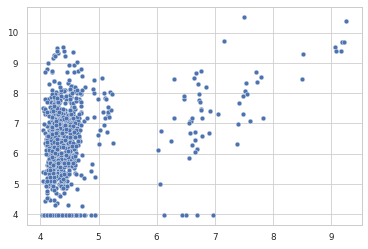

In [76]:
sns.scatterplot(x=old_preds, y=y_test.values,)

In [80]:
old_reg.score(X=X_test, y=y_test, sample_weight=[1 if px_val >= 4 else 0.1 for px_val in y_test])

-3.297444820606575